<a href="https://colab.research.google.com/github/RautRitesh/langgraph/blob/main/Lanngraph_corrective_rag_self_rag_and_agentic_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook we will try to create the production ready different RAG approaches that langgraph supports

### We will start with creating a corrective rag which will grade the document and generate the best answer

In [ ]:
pip install tavily-python langchain-tavily


In [ ]:
pip install langchain langgraph langchain-core langchain-community langchain-groq langchain faiss-cpu langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
# let us understand how the document grader works first by creating the retriever using faiss

from langchain_community.document_loaders import TextLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_tavily import TavilySearch


In [ ]:
loader=TextLoader("/content/nepal_insurance_details.txt")
docs=loader.load()

In [ ]:
embeddings=HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
text_splitter=RecursiveCharacterTextSplitter(chunk_overlap=200, chunk_size=800,separators=["\n\n","\n"])
chunk=text_splitter.split_documents(docs)
vector_stores=FAISS.from_documents(chunk, embeddings)

In [ ]:
retriever=vector_stores.as_retriever(search_kwargs={"k":4})

In [ ]:
result=retriever.invoke("What is the document about?")

In [ ]:
print(result)

[Document(id='1f2c436d-da46-4ad4-9ed1-6f7c57babdab', metadata={'source': '/content/nepal_insurance_details.txt'}, page_content='Enrollment Procedure\nCitizens enroll via local Enrollment Assistants (volunteers) at ward offices, health posts, or empaneled facilities using the Insurance Management Information System (IMIS). Provide citizenship certificate, photos, and pay NPR 3,500 annually for a standard family (recent figure); receive a health insurance card instantly or shortly after.'), Document(id='0bda86fa-c210-47ac-9d47-84e41401ef36', metadata={'source': '/content/nepal_insurance_details.txt'}, page_content='Description of the tests provided free of charge by specific government programs (outside of the standard Health Insurance Board coverage) are:'), Document(id='55102e7f-4fd7-4fd2-adf2-ed0dc93e6e4d', metadata={'source': '/content/nepal_insurance_details.txt'}, page_content='Pay Co-Pay: Cover 20% of approved costs immediately (e.g., NPR 200 on a NPR 1,000 bill); no upfront payme

In [ ]:
for doc in result:
  print(doc.id)
  print(doc.metadata)
  print(doc.page_content)
  print("\n\n-------")

## This is the data that we get from the retriever, now we will use this data to check if it is correct or not than only we will go with the generation ,hence this is the implementation of the corrective rag

# Using and settin up the data now

In [ ]:
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph , START , END
from langgraph.prebuilt import ToolNode
from typing import Literal
from langchain_core.tools import tool
from pydantic import BaseModel , Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.output_parsers import StrOutputParser

In [ ]:
from google.colab import userdata
api_key=userdata.get('groq_api_key')
tavily_api_key=userdata.get('Tavily_api_key')

In [ ]:
llm=ChatGroq(model="openai/gpt-oss-20b",api_key=api_key)
memory=MemorySaver()

In [ ]:
class AgentState(MessagesState):
  document:list[str]
  web_search:str

In [ ]:
class GradeDocument(BaseModel):
  binary_score:Literal["yes","no"]=Field(description="Choose yes or no based the user question  related to medical or not")

In [ ]:
llm_with_structured_output=llm.with_structured_output(GradeDocument)

In [ ]:
system="""You are an assistant used for grading the document and the user question are related with each other or not , if related than
set it as 'yes' else 'no' based on the document provided by the user"""
prompt=ChatPromptTemplate([
    ("system",system),
    ("human","Based on this document{document} for this question {question}")
])
retreiver_grader=prompt | llm_with_structured_output

In [ ]:
system_2="""You are an advance query rewriter that transform the user query to the best query for tavily search first understand the user query and generate the best alternative, rewrite the question closer to the acutal one"""
prompt_query_rewriter=ChatPromptTemplate([
    ("system",system_2),
    ("human","Generate the best question for this {question}")
])
query_rewriter=prompt_query_rewriter|llm|StrOutputParser()


In [ ]:
system_3="""You are an advance answer generator, generate the best answer on the given question using the available document"""
prompt_llm_generator=ChatPromptTemplate(
    [
        ("system",system_3),
        ("user","Document {document} and question is {question}\n")
    ]
)
llm_generator=prompt_llm_generator|llm|StrOutputParser()

In [ ]:
def retriever_rag(state:AgentState):
  query=state["messages"][-1].content
  docs=retriever.invoke(query)
  return {"document":docs}


In [ ]:
def router1(state:AgentState)->Literal["generator","query_rewriter"]:
  user_query=state["messages"][-1].content
  docs=state["document"]
  filtered_docs=[]
  for doc in docs:
    filtered_docs.append(doc.page_content)
  actual_text="\n".join(doc for doc in filtered_docs)
  response=retreiver_grader.invoke({"question":{user_query},"document":{actual_text}})
  if response.binary_score== "yes":
    return "generator"
  else:
    print("returning query_rewriter")
    return "query_rewriter"


In [ ]:
def query_rewriter(state:AgentState):
  user_query=state["messages"][-1].content
  new_query=query_rewriter.invoke({"question":{user_query}})
  return {"messages":[new_query]}

In [ ]:
tavily_search=TavilySearch(tavily_api_key=tavily_api_key)

In [ ]:
def websearch(state:AgentState):
  message=state["messages"][-1]
  response=tavily_search.invoke(message.content)
  return {"document":[response],"web_search":"yes"}



In [ ]:
def generate(state:AgentState):
  response_source=state.get("websearch","no")
  print(response_source)
  query=state["messages"][-1]
  document=state["document"]
  if response_source == "yes":
    response=llm_generator.invoke({"question":query, "document":document})
  else:
    filtered_docs=[]
    for doc in document:
      filtered_docs.append(doc.page_content)
    actual_text="\n".join(doc for doc in filtered_docs)
    response=llm_generator.invoke({"question":query,"document":actual_text})
    print(response)
    return {"messages":[response]}



In [ ]:
workflow=StateGraph(AgentState)
workflow.add_node("retriever",retriever_rag)
workflow.add_node("query_rewriter",query_rewriter)
workflow.add_node("websearch",websearch)
workflow.add_node("generator",generate)
workflow.add_edge(START, "retriever")
workflow.add_conditional_edges("retriever",router1,{"generator":"generator","query_rewriter":"query_rewriter"})
workflow.add_edge("query_rewriter","websearch")
workflow.add_edge("websearch","generator")
workflow.add_edge("generator",END)
app=workflow.compile(checkpointer=memory)


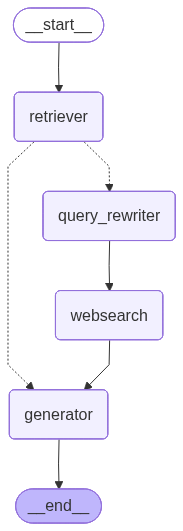

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [ ]:
config={"configurable":{"thread_id":"1"}}

In [ ]:
response=app.invoke({"messages":"How can i do goverment insurance in Nepal?"},config=config)

### New Task is to use the agent with memory 😿😿🔦🔦🔦 , so that the agent will remember all the past chat messages

In [ ]:
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain_community.document_loaders import TextLoader
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START , END
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_tavily import TavilySearch
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from typing import Literal
from langchain_core.messages import HumanMessage

In [ ]:
from google.colab import userdata
tavily_api_key=userdata.get('Tavily_api_key')
api_key=userdata.get('groq_api_key')


In [ ]:
llm=ChatGroq(model="openai/gpt-oss-120b",api_key=api_key)

In [ ]:
tavily_search= TavilySearch(tavily_api_key=tavily_api_key)

In [ ]:
loader=TextLoader("/content/nepal_insurance_details.txt")
docs=loader.load()

In [ ]:
text_splitter=RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, separators=["\n\n","\n"])

In [ ]:
chunk=text_splitter.split_documents(docs)
embeddings=HuggingFaceEmbeddings(
    model="sentence-transformers/all-MiniLM-L6-v2"
)
vector_stores=FAISS.from_documents(chunk,embeddings)
retriever=vector_stores.as_retriever(search_kwargs={"k":3})

In [ ]:
class AgentState(MessagesState):
  document:list[str]
  web_search:str


In [ ]:
class GradeDocument(BaseModel):
  binary_score:Literal["yes","no"]=Field(description="either choose yes or no for the given answer being related to the document or not")

In [ ]:
system_1="""You are an advanced grader based on the given question and is generated document relevant or not if relevant than return yes else no """
prompt_grader=ChatPromptTemplate([
    ("system",system_1),
    ("user","the question is {question} and the document is {document}")
])
llm_with_structured_output=llm.with_structured_output(GradeDocument)
llm_grader=prompt_grader | llm_with_structured_output

In [ ]:
system_2="""You are a best question rewriter take the question and also go through all the avaialble chat history to create better question"""
prompt_query_rewriter=ChatPromptTemplate(
    [
        ("system",system_2),
        MessagesPlaceholder(variable_name="chat_history"),
        ("user","the previous question is {question}")
    ]
)
llm_query_rewriter=prompt_query_rewriter | llm | StrOutputParser()


In [ ]:
system_3="""You are best answer generator agent, on the basis of the given document , for the question generate the best answer, for your knowledge of user context we have added the chat history"""
prompt_generator=ChatPromptTemplate([
    ("system",system_3),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user","the user question is {question} and the document is {document}")
])
llm_generator= prompt_generator | llm | StrOutputParser()

In [ ]:
def retriever_query(state:AgentState):
  print("hello")
  query=state["messages"][-1].content
  print("got here")
  result=retriever.invoke(str(query))
  formatted_docs=[]
  for doc in result:
    formatted_docs.append(doc.page_content)
  return {"document":formatted_docs}

In [ ]:
def router(state:AgentState)->Literal["generator","query_rewriter"]:
  query=state["messages"][-1]
  document=state["document"]
  print(query)
  response=llm_grader.invoke({"question":query.content,"document":document})
  if response.binary_score=="yes":
    return "generator"
  else:
    return "query_rewriter"





In [ ]:
def query_rewriter(state:AgentState):
  query=state["messages"][-1]
  chat_history=state["messages"][:-1]
  new_query=llm_query_rewriter.invoke({"question":query.content,"chat_history":chat_history})
  return {"messages":[new_query]}

In [ ]:
def websearch(state:AgentState):
  query=state["messages"][-1]
  response=tavily_search.invoke(query.content)
  return {"document":response, "websearch":"yes"}

In [ ]:
def generate(state:AgentState):
  query=state["messages"][-1]
  document=state["document"]
  chat_history=state["messages"][:-1]
  web_search=state.get("websearch","no")
  if web_search=="yes":
    result=llm_generator.invoke({"question":query.content,"document":document,"chat_history":chat_history}) # Changed 'messages' to 'question' and used query.content
    return {"messages":[result]} # Changed 'response' to 'result'
  else:
    actual_text="\n".join(doc for doc in document)
    print("from the acutal text retirever---------------------\n")
    print(actual_text)
    result=llm_generator.invoke({"question":query.content, "document":actual_text,"chat_history":chat_history}) # Changed 'messages' to 'question' and used query.content
    return {"messages":[result]} # Added missing return statement

In [ ]:
memory=MemorySaver()

In [ ]:
workflow2=StateGraph(AgentState)
workflow2.add_node("retriever",retriever_query)
workflow2.add_node("query_rewriter",query_rewriter)
workflow2.add_node("websearch",websearch)
workflow2.add_node("generator",generate)
workflow2.add_edge(START, "retriever")
workflow2.add_conditional_edges("retriever",router, {"generator":"generator","query_rewriter":"query_rewriter"})
workflow2.add_edge("query_rewriter","websearch")
workflow2.add_edge("websearch","generator")
workflow2.add_edge("generator",END)
app2=workflow2.compile(checkpointer=memory)

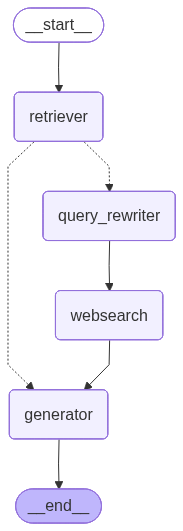

In [ ]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [ ]:
config={"configurable":{"thread_id":"2"}}

In [ ]:
response=app2.invoke({"messages":"what is the document is about?"},config=config)

hello
got here
content='what is the document is about?' additional_kwargs={} response_metadata={} id='1ea7d406-0509-48ac-bea9-af15974247ef'
from the acutal text retirever---------------------

Enrollment Procedure
Citizens enroll via local Enrollment Assistants (volunteers) at ward offices, health posts, or empaneled facilities using the Insurance Management Information System (IMIS). Provide citizenship certificate, photos, and pay NPR 3,500 annually for a standard family (recent figure); receive a health insurance card instantly or shortly after.
Get Treatment: Receive services; hospital bills the HIB for the 80% reimbursement directly through IMIS no manual claim forms needed from you.
Referrals if Needed: For specialized care at higher-level hospitals, get a free referral slip from the current facility; coverage follows at the next empaneled site.
Digital Verification: IMIS instantly checks eligibility, limits (NPR 100,000/family annually), and deductibles; get a receipt summarizin

In [ ]:
print(response)

{'messages': [HumanMessage(content='what is the document is about?', additional_kwargs={}, response_metadata={}, id='c6b5a0f6-1412-448b-80d1-4cca623b1b4d'), HumanMessage(content='The document explains how Nepal’s National Health Insurance Program (NHIP) works. It describes:\n\n* **Enrollment** – citizens register through local volunteers using the Insurance Management Information System (IMIS), provide a citizenship certificate and photos, and pay an annual premium (≈\u202fNPR\u202f3,500 for a standard family). They receive an insurance card instantly.\n\n* **Getting treatment** – when a card‑holder visits an empaneled hospital or health post, the facility bills the Health Insurance Board (HIB) for 80\u202f% of the approved cost through IMIS; the patient pays the 20\u202f% co‑pay (or none for vulnerable groups).\n\n* **Referrals** – free referral slips are issued for higher‑level care, and coverage follows to the next empaneled facility.\n\n* **Digital verification** – IMIS checks elig

In [ ]:
response=app2.invoke({"messages":"what was my previous question?"},config=config)
print(response)

hello
got here
content='what was my previous question?' additional_kwargs={} response_metadata={} id='254eafa6-b863-4d36-ab25-5639f871a580'
from the acutal text retirever---------------------

query
follow_up_questions
answer
images
results
response_time
request_id
{'messages': [HumanMessage(content='what is the document is about?', additional_kwargs={}, response_metadata={}, id='c6b5a0f6-1412-448b-80d1-4cca623b1b4d'), HumanMessage(content='The document explains how Nepal’s National Health Insurance Program (NHIP) works. It describes:\n\n* **Enrollment** – citizens register through local volunteers using the Insurance Management Information System (IMIS), provide a citizenship certificate and photos, and pay an annual premium (≈\u202fNPR\u202f3,500 for a standard family). They receive an insurance card instantly.\n\n* **Getting treatment** – when a card‑holder visits an empaneled hospital or health post, the facility bills the Health Insurance Board (HIB) for 80\u202f% of the approved 

### Now let us build an agent that is able to use the rag tool and produce output if not got than must be able to say the answer using the tools and if not than generate the simple answer

In [ ]:
pip install faiss-cpu langchain langgraph langchain-huggingface langchain-groq langchain-community langchain-core

In [ ]:
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.document_loaders import  TextLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser

In [ ]:
from google.colab import userdata
api_key=userdata.get('groq_api_key')

In [ ]:
loader=TextLoader("/content/nepal_insurance_details.txt")
docs=loader.load()

In [ ]:
embeddings=HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")
llm=ChatGroq(model="openai/gpt-oss-120b",api_key=api_key)


In [ ]:
class DocumentGrader(BaseModel):
  binary_score:Literal["yes","no"]=Field(description="Please grade whether the given document is related to the question or not")

In [ ]:
llm_with_structured_output=llm.with_structured_output(DocumentGrader)


In [ ]:
system_1="""You are an advanced agent with task to check whether the documents are related to the user question or not"""
prompt_grader=ChatPromptTemplate([
    ("system",system_1),
    ("human","The question is {question} and document is {document}")
])
llm_grader=prompt_grader | llm_with_structured_output

In [ ]:
system_2="""Your a best answer generator , generate the best answer for the question , on the basis of the given context"""
promt_generator=ChatPromptTemplate([
    ("system",system_2),
    ("human","The question is {question} and context is {context}")
])
llm_generator=promt_generator | llm | StrOutputParser()

In [ ]:
system_3="""You are best question rewriter ,generate the best question for the llm to process , you have access to the past questions"""
prompt_rewriter=ChatPromptTemplate([
    ("system",system_3),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human","The question is {question}")
])
llm_rewritere=prompt_rewriter | llm | StrOutputParser()

In [ ]:
text_splitter=RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200,separators=["\n\n","\n"])
chunk=text_splitter.split_documents(docs)
vector_stores=FAISS.from_documents(chunk,embeddings)
retriever=vector_stores.as_retriever(search_kwargs={"k":3})


In [ ]:
@tool
def search(query:str):
  """This tool is used for searching for the medical data of nepal especially for medical insurance"""
  response=retriever.invoke(query)
  filtered_docs=[]
  for doc in response:
    filtered_docs.append(doc.page_content)
  actual_text="\n".join(doc for doc in filtered_docs)
  return actual_text



In [ ]:
tools=[search]

In [ ]:
llm_with_tools=llm.bind_tools(tools=tools)

In [ ]:
def agent_node(state:MessagesState):
  user_query=state["messages"]
  system_message=SystemMessage(content="You are advanced agent with the tools such as `search`, use this tools if user query is related to medical else simply give response to user message")
  response=llm_with_tools.invoke([system_message]+user_query)
  return {"messages":[response]}


In [ ]:
def router1(state:MessagesState)->Literal["tools",END]:
  last_message=state["messages"][-1]
  if last_message.tool_calls:
    print("got tool calls")
    return "tools"
  else:
    print("no tool call required")
    return END

In [ ]:
def router2(state:MessagesState)->Literal["query_rewriter","generator"]:
  user_query=state["messages"][-2].content
  response=state["messages"][-1].content
  response_2=llm_grader.invoke({"question":user_query, "document":response})
  if response_2.binary_score=="yes":
    return "generator"
  else:
    return "query_rewriter"



In [ ]:
def generator_node(state:MessagesState):
  user_query=state["messages"][-2].content
  document=state["messages"][-1].content
  response=llm_generator.invoke({"question":user_query},{"context":document})
  return {"messages":[response]}




In [ ]:
def rewriter_node(state:MessagesState):
  user_query=state["messages"][-2].content
  previous_messages=state["messages"][:-2]
  human_message=[m for m in previous_messages if isinstance(m,HumanMessage)]
  response=llm_rewritere.invoke({"question":user_query,"chat_history":human_message})
  return {"messages":[response]}


In [ ]:
workflow=StateGraph(MessagesState)
workflow.add_node("agent_node",agent_node)
workflow.add_node("vector_retriever",ToolNode(tools))
workflow.add_node("query_rewriter",rewriter_node)
workflow.add_node("generator",generator_node)
workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges("agent_node",router1, {"tools":"vector_retriever",END:END})
workflow.add_conditional_edges("vector_retriever",router2,{"generator":"generator","query_rewriter":"query_rewriter"})
workflow.add_edge("query_rewriter","agent_node")
workflow.add_edge("generator",END)

In [ ]:
memory=MemorySaver()

In [ ]:
app=workflow.compile(checkpointer=memory)

In [ ]:
config={"configurable":{"thread_id":"1"}}

In [ ]:
events=app.stream({"messages":"list of hospitals of jhapa?"},config=config,stream_mode="values")
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

list of hospitals of jhapa?
got tool calls
================================== Ai Message ==================================
Tool Calls:
  search (fc_0af758ef-16e7-4323-9303-88780e04a1e2)
 Call ID: fc_0af758ef-16e7-4323-9303-88780e04a1e2
  Args:
    query: Jhapa district hospitals list Nepal
================================= Tool Message =================================
Name: search

Kanchanpur
Hospitals: Mahakali Hospital. 
PHC: Beldadi PHC, Dodhara PHC, Shreepur PHC. 

Dadeldhura
Hospitals: Dadeldhura Hospital (Sub-regional), Jogabudha Hospital. 

Other Districts (Sudurpashchim)
Achham: Achham District Hospital, Bayalpata Hospital. 
Baitadi: District Hospital Baitadi. 
Bajhang: District Hospital Bajhang. 
Bajura: Bajura Hospital. 
Darchula: District Hospital Darchula, Gokuleswor Hospital. 
Doti: District Hospital Doti.
Saptari
Hospitals: Gajendra Narayan Singh Hospital, Bhardah Hospital. 
PHC: Kadarbona

### For creating self rag , it is similar to the agentic rag but instead of grading document we grade every response to check whether the model is hallunicating👸👸👸 or generating better response. It is called self rag because we review whether the response is useful or not. It follows the following process:

1.   First we grade the document whether the retiever is generating relevant docs or not
2.   Now again we check whether the generator node is generating correct response on the basis of the retireved docs or not
3. and for transforming or rewriting the query we will simply do one thing and that is we also check whether the user question and relevant docs has relation or not, if not than we will simply stop the loop else the agent will rewrite and generate the better response



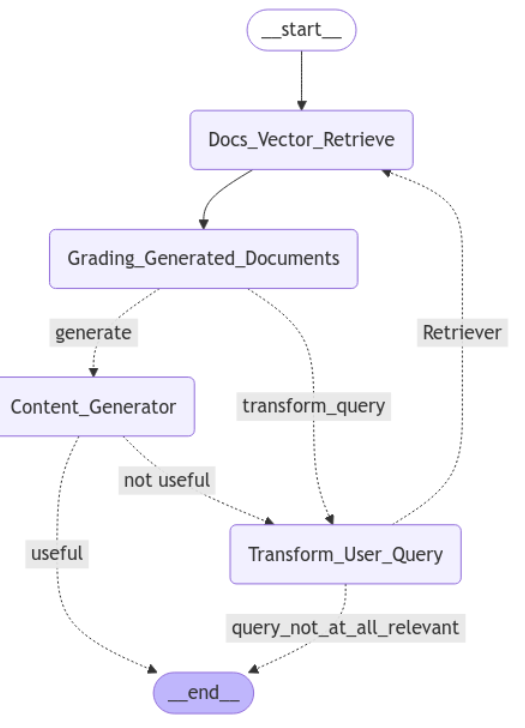